# Explainable AI - GradCAM

## Imports

In [2]:
import numpy as np
import scipy
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

## Loading

### Model

In [3]:
grad_model = load_model('/kaggle/input/6-data-for-explainableai/grad_model.h5', compile=False)

### Data

In [3]:
data_test = pd.read_csv('/kaggle/input/6-data-for-explainableai/data_test.csv')
data_train = pd.read_csv('/kaggle/input/6-data-for-explainableai/data_train.csv')
data_val = pd.read_csv('/kaggle/input/6-data-for-explainableai/data_val.csv')

labels_test = pd.read_csv('/kaggle/input/6-data-for-explainableai/labels_test.csv')
labels_train = pd.read_csv('/kaggle/input/6-data-for-explainableai/labels_train.csv')
labels_val = pd.read_csv('/kaggle/input/6-data-for-explainableai/labels_val.csv')

## Create data generators

In [4]:
# This class is a customer data generator 
# It's purpose is to load, preprocess and supply data in batches during training
# It's there because it is inefficient to load large datasets at once
    
class ECG_DataGen(tf.keras.utils.Sequence):    
# Contructor - Takes a list of ECG files and labels, batch size (number of samples ), sample length (number of data points in each ECG signal), and an option to shuffle the data. 
    def __init__(self, df_files, df_labels, data_col, batch_size, sample_len, shuffle=True):
        #self is an instance of the class #it should be passed as first parameter in all methods
        
        self.df_files = df_files.copy()
        self.df_labels = df_labels.copy()
        self.data_col = data_col
        self.n_samples = len(self.df_files)
        self.sample_len = sample_len
        self.batch_size = batch_size
        self.shuffle = shuffle
        
    def __len__(self):
        return self.n_samples // self.batch_size
    
#     applies low pass filter
    def low_pass_filter(self, voltages, window_size):
        """Applies a moving average low-pass filter to a 1D array of voltages."""
        # Create a windowed version of the array
        window = np.ones(window_size) / window_size
        filtered_voltages = np.convolve(voltages, window, mode='same')
        return filtered_voltages
    
#    normalizes data and apply low pass filter
    def scale(self, array):
        # Replace NaN values with 0.0
        array = np.nan_to_num(array, nan=0.0)
        
        #apply low pass filter
        array = self.low_pass_filter(array, window_size=100)

        # normalizing
        a_min = np.min(array)
        a_max = np.max(array)
        if a_max - a_min == 0:
            return np.zeros_like(array).reshape((-1, 1))
        return np.array((array - a_min) / (a_max - a_min))
       
#   TO BE SEARCHED  -  loads, preprocesses (filters and normalizes), and formats the data in chunks (batches) and returns it to the model.    
    def __getitem__(self, index):
        batch_leads = np.zeros((self.batch_size, self.sample_len, 12)) #create array with shape 128, 5000, 12
        batch_labels = np.zeros((self.batch_size, len(self.df_labels.columns))) 

        for i in range(index*self.batch_size, (index+1)*self.batch_size):

            # load the ECG signals
            leads = scipy.io.loadmat(self.df_files.at[i, self.data_col])['val'] #loadmat() is a function to load matlab files #self.df_files.at[i, self.data_col] is the file path
            
            for j, lead_data in enumerate(leads): #iterate through 12 leads
                #preprocess data (normalize, filter)
                scaled_lead_data = self.scale(lead_data)
                
                batch_leads[i - index*self.batch_size, :, j] = scaled_lead_data.reshape((-1,))
            batch_labels[i - index*self.batch_size] = self.df_labels.loc[i].values
        return batch_leads, batch_labels

    #  called at the end of every training epoch to shuffle data after every epoch
    def on_epoch_end(self):
        if self.shuffle: 
            shuffle_idx = np.random.choice(range(self.n_samples), size=self.n_samples, replace=False)
            self.df_files = self.df_files.iloc[shuffle_idx].reset_index(drop=True)
            self.df_labels = self.df_labels.iloc[shuffle_idx].reset_index(drop=True)

In [5]:
data_col = 'ecg_filename'
sample_len = 5000
batch_size= 128

# Create data generators (Objects from ECG_DataGen class)
# These generators do not store the data themselves; instead, they load, preprocess, and return batches of ECG data and corresponding labels during model training or evaluation.
train_gen = ECG_DataGen(data_train, labels_train, data_col, batch_size, sample_len)
val_gen = ECG_DataGen(data_val, labels_val, data_col, batch_size, sample_len)
test_gen = ECG_DataGen(data_test, labels_test, data_col, len(data_test), sample_len)

In [6]:
# Extract a batch of data
X, _ = train_gen.__getitem__(0)  # Get the first batch
X.shape

(128, 5000, 12)

# Function to compute GradCAM heatmap

In [4]:
grad_model = keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer('conv1d').output, model.output]
    )

In [5]:
grad_model.save('grad_model.h5')

In [11]:
input_data = X[:1]
inputs = tf.cast(input_data, tf.float32)

In [12]:
conv_outputs, predictions = grad_model(inputs)

In [27]:
predictions

<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[5.6984392e-04, 4.2919274e-03, 4.5942995e-04, 5.8690803e-03,
        1.2871161e-03, 3.7474239e-03, 1.5965709e-03, 1.2336003e-03,
        4.2030998e-03, 1.2841440e-03, 5.3785823e-04, 6.3312757e-03,
        6.3450453e-03, 4.7195023e-03, 1.3454980e-03, 3.7232393e-03,
        3.2017316e-04, 1.1180786e-03, 1.4623572e-01, 8.0478138e-01]],
      dtype=float32)>

In [26]:
conv_outputs

<tf.Tensor: shape=(1, 4998, 32), dtype=float32, numpy=
array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.00240608, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]], dtype=float32)>

In [25]:
conv_outputs.shape

TensorShape([1, 4998, 32])

In [28]:
conv_outputs[0]

<tf.Tensor: shape=(4998, 32), dtype=float32, numpy=
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.00240608, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)>

In [13]:
pred_index = tf.argmax(predictions[0])

In [ ]:
class_channel = predictions[:, 19]
class_channel

In [18]:
class_channel = predictions[:, pred_index]
class_channel

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.8047814], dtype=float32)>

In [22]:
loss = class_channel

In [ ]:
# Function to compute GradCAM heatmap for a specific lead
def get_gradcam_heatmap(model, input_data, lead_number, class_index = None):
    print("Creating GradCAM model...")
    # Create a model that outputs both the convolutional layer (conv1) and the predictions
    
    # grad_model: A new model that takes same input as original model. Outputs both the activations from the first convolutional layer (conv1d) and the final predictions
    grad_model = keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer('conv1d').output, model.output] #model.get_layer('conv1d').output gives the activation/feature map produced by the convolutional layer when data passes through it during a forward pass. 
    )
    print("GradCAM model created successfully.")

    print("Performing forward pass...")
    # Forward pass through the model to get activations and predictions 
    #forward pass is the the process of passing input data through the model's layers to produce an output
    # Activations are the outputs produced by each layer in a neural network as the input data passes through it. 
   
    # tf.GradientTape(): Records operations for automatic differentiation.
    with tf.GradientTape() as tape:
        inputs = tf.cast(input_data, tf.float32) #convert input_data to type tf.float32
        
        # tape.watch(inputs): Watches the input tensor for gradient computation. 
        # gradient computation is a way for a model to figure out how much each part of the input affects the final result.
        tape.watch(inputs)

        # grad_model(inputs) apply forward pass through grad_model to get activations and predictions.
        conv_outputs, predictions = grad_model(inputs)
        if class_index is None:
            class_index = tf.argmax(predictions[0])

        # loss: Focuses on the prediction probability for the specified class_index. #e.g: <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.8047814], dtype=float32)>
        loss = predictions[:, class_index]  # Compute the loss with respect to the desired class
    print("Forward pass completed.")

    # Compute the gradient of the loss with respect to the convolutional layer output
    print("Computing gradients...")

    # Computes the gradient of the loss with respect to the convolutional layer's output. 
    # gradients are a way of measuring how much a change in one part of a system affects the outcome.
    grads = tape.gradient(loss, conv_outputs)
    print("Gradients computed successfully.")

    # Extract the gradients and activations for the specific lead
    print("Extracting lead-specific gradients and activations...")
    grads = grads[:, :, lead_number]  # Extract gradients for the specific lead
    conv_outputs = conv_outputs[:, :, lead_number]  # Extract activations for the specific lead

    # Compute the guided gradients (ReLU applied to gradients)
    print("Calculating pooled gradients...")
    pooled_grads = tf.reduce_mean(grads, axis=0) #Averages the gradients across the batch and time dimensions to get a single value per feature map.
    print("Pooled gradients calculated.")

    # Multiply the output of the convolutional layer by the gradients and take the average
    #conv_outputs.shape = (1,4998,32) #conv_outputs[0].shape = (4998,32)
    conv_outputs = conv_outputs[0]

    print("Applying pooled gradients to convolutional outputs...")
    conv_outputs = tf.multiply(conv_outputs, pooled_grads)  # Element-wise multiplication of activation maps and pooled gradients
    print("GradCAM feature maps updated.")

    # Apply ReLU to remove negative values and normalize the heatmap
    print("Generating heatmap...")

    # np.maximum() compares two values and returns the maximum, so if conv_numpy is negative, 0 is returned
    heatmap = np.maximum(conv_outputs.numpy(), 0) #applies ReLU to focus only on positive influences.
    if np.max(heatmap) != 0:
        heatmap /= np.max(heatmap)
    print("Heatmap generated successfully.")

    return heatmap

In [13]:
# Function to compute GradCAM heatmap by considering all leads together
def get_gradcam_heatmap_all_leads(model, input_data, class_index=None):
    print("Creating GradCAM model...")
    # Create a model that outputs both the convolutional layer (conv1) and the predictions
    grad_model = keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer('conv1d').output, model.output]
    )
    print("GradCAM model created successfully.")

    print("Performing forward pass...")
    # Forward pass through the model to get activations and predictions
    with tf.GradientTape() as tape:
        inputs = tf.cast(input_data, tf.float32)
        tape.watch(inputs)
        conv_outputs, predictions = grad_model(inputs)
        
        if class_index is None:
            class_index = tf.argmax(predictions[0])
          
        loss = predictions[:, class_index]  # Compute the loss with respect to the desired class
    print("Forward pass completed.")

    # Compute the gradient of the loss with respect to the convolutional layer output
    print("Computing gradients...")
    grads = tape.gradient(loss, conv_outputs)
    print("Gradients computed successfully.")

    # Compute the guided gradients (ReLU applied to gradients)
    print("Calculating pooled gradients...")
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    print("Pooled gradients calculated.")

    # Multiply the output of the convolutional layer by the pooled gradients
    print("Applying pooled gradients to convolutional outputs...")
    conv_outputs = conv_outputs[0]
    conv_outputs = tf.multiply(conv_outputs, pooled_grads)  # Element-wise multiplication
    print("GradCAM feature maps updated.")

    # Average the feature maps along the channels to get the heatmap
    print("Generating heatmap...")
    heatmap = tf.reduce_mean(conv_outputs, axis=-1).numpy()

    # Apply ReLU to remove negative values and normalize the heatmap
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) != 0:
        heatmap /= np.max(heatmap)
    print("Heatmap generated successfully.")

    return heatmap

In [14]:
# Function to display the GradCAM heatmap on top of the ECG signal
def plot_ecg_with_gradcam(ecg_signal, heatmap, lead_number):
    print(f"Plotting ECG signal for Lead {lead_number + 1}...")
    plt.figure(figsize=(10, 5))
    
    # Plot the ECG signal for the specified lead
    print(f"Plotting ECG signal with shape: {ecg_signal[:, lead_number].shape}")
    plt.plot(ecg_signal[:, lead_number], label=f'ECG Signal (Lead {lead_number + 1})')
    
    # Resize heatmap to the same size as the ECG signal
    print("Resizing heatmap to match ECG signal length...")
    heatmap_resized = np.interp(np.arange(0, ecg_signal.shape[0]), np.linspace(0, len(heatmap), len(heatmap)), heatmap)
    print(f"Heatmap resized with shape: {heatmap_resized.shape}")
    
    # Plot the heatmap as an overlay (scaled for visibility)
    print("Overlaying heatmap on ECG signal...")
    plt.imshow(np.expand_dims(heatmap_resized, axis=0), aspect='auto', cmap='jet', alpha=0.5, extent=[0, ecg_signal.shape[0], np.min(ecg_signal[:, lead_number]), np.max(ecg_signal[:, lead_number])])
    
    plt.title(f"ECG Signal with GradCAM Heatmap (Lead {lead_number + 1})")
    plt.show()
    print("ECG with GradCAM heatmap plotted successfully.")

# Function to display the GradCAM heatmap on top of all 12 ECG leads
def plot_ecg_with_gradcam_all_leads(ecg_signal, heatmaps):
    print("Plotting ECG signals for all 12 leads...")
    fig, axes = plt.subplots(6, 2, figsize=(15, 20)) #axes is a 2D array of subplots created by plt.subplots(6, 2)
    axes = axes.flatten() # axes.flatten() flattens it to a 1D array, this way subplots can easily be accessed
    
    for lead_number in range(12):
        ax = axes[lead_number] #ax is a specific subplot
        print(f"Plotting ECG signal for Lead {lead_number + 1}...")
        # Plot the ECG signal for the specified lead
        ax.plot(ecg_signal[:, lead_number], label=f'ECG Signal (Lead {lead_number + 1})')
        
        # Resize heatmap to the same size as the ECG signal
        print(f"Resizing heatmap for Lead {lead_number + 1} to match ECG signal length...")
        #np.interp(): Resizes the heatmap to match the length of the ECG signal (5000 time points). 
        # np.arrange() - returns evenly spaced values within a specified range similar to Python's built-in range() but for NumPy arrays
        # np.linspace() - generates an array of evenly spaced values between a specified start and stop, but specify how many values wanted
        heatmap_resized = np.interp(np.arange(0, ecg_signal.shape[0]), 
                                    np.linspace(0, len(heatmaps[lead_number]), len(heatmaps[lead_number])), 
                                    heatmaps[lead_number])
        print(f"Heatmap resized with shape: {heatmap_resized.shape}")
        
        # Plot the heatmap as an overlay (scaled for visibility)
        print(f"Overlaying heatmap on ECG signal for Lead {lead_number + 1}...")
        
        # ax.imshow(): Overlays the resized heatmap on top of the ECG signal
        # ('jet : semi-transparent colormap  
        ax.imshow(np.expand_dims(heatmap_resized, axis=0), aspect='auto', cmap='Reds', alpha=0.5, 
                  extent=[0, ecg_signal.shape[0], np.min(ecg_signal[:, lead_number]), 
                          np.max(ecg_signal[:, lead_number])])
        
        ax.set_title(f"ECG Signal with GradCAM Heatmap (Lead {lead_number + 1})")
        ax.set_xlabel('Time')
        ax.set_ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()
    print("All 12 ECG leads with GradCAM heatmaps plotted successfully.")

## Single heat map plot

Generating GradCAM heatmap...
Creating GradCAM model...
GradCAM model created successfully.
Performing forward pass...
Forward pass completed.
Computing gradients...
Gradients computed successfully.
Extracting lead-specific gradients and activations...
Calculating pooled gradients...
Pooled gradients calculated.
Applying pooled gradients to convolutional outputs...
GradCAM feature maps updated.
Generating heatmap...
Heatmap generated successfully.
Plotting the GradCAM heatmap for Lead 1...
Plotting ECG signal for Lead 1...
Plotting ECG signal with shape: (5000,)
Resizing heatmap to match ECG signal length...
Heatmap resized with shape: (5000,)
Overlaying heatmap on ECG signal...


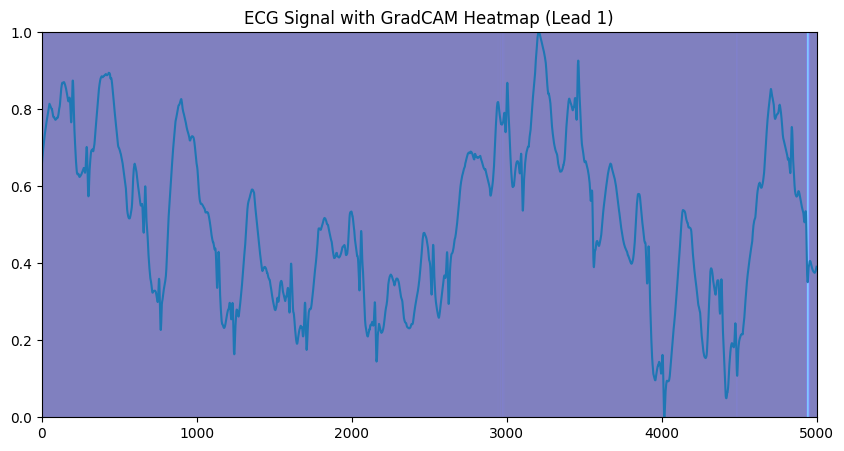

ECG with GradCAM heatmap plotted successfully.
GradCAM visualization completed.


In [26]:
# Generate GradCAM for a specific class
print("Generating GradCAM heatmap...")
ecg_input = X[:1]  # Choose one ECG record from the batch
# class_index = 19  # Change this based on the class to explain
lead_number = 0  # Change this to select a different lead (0-11 for 12 leads)

# Compute the GradCAM heatmap for the specified lead
heatmap = get_gradcam_heatmap(model, ecg_input, lead_number)

# Plot the result with the ECG signal for a specific lead
print(f"Plotting the GradCAM heatmap for Lead {lead_number + 1}...")
plot_ecg_with_gradcam(ecg_input[0], heatmap, lead_number)
print("GradCAM visualization completed.")

## All heatmap plot

Same heatmap for all leads

In [17]:
print("Generating GradCAM heatmap considering all leads...")
ecg_input = X[:1]  # Choose one ECG record from the batch
class_index = 19  # Change this based on the class wanted to explain
heatmap_all_leads = get_gradcam_heatmap_all_leads(model, input_data, class_index)

Generating GradCAM heatmap considering all leads...
Creating GradCAM model...
GradCAM model created successfully.
Performing forward pass...
Forward pass completed.
Computing gradients...
Gradients computed successfully.
Calculating pooled gradients...
Pooled gradients calculated.
Applying pooled gradients to convolutional outputs...
GradCAM feature maps updated.
Generating heatmap...
Heatmap generated successfully.


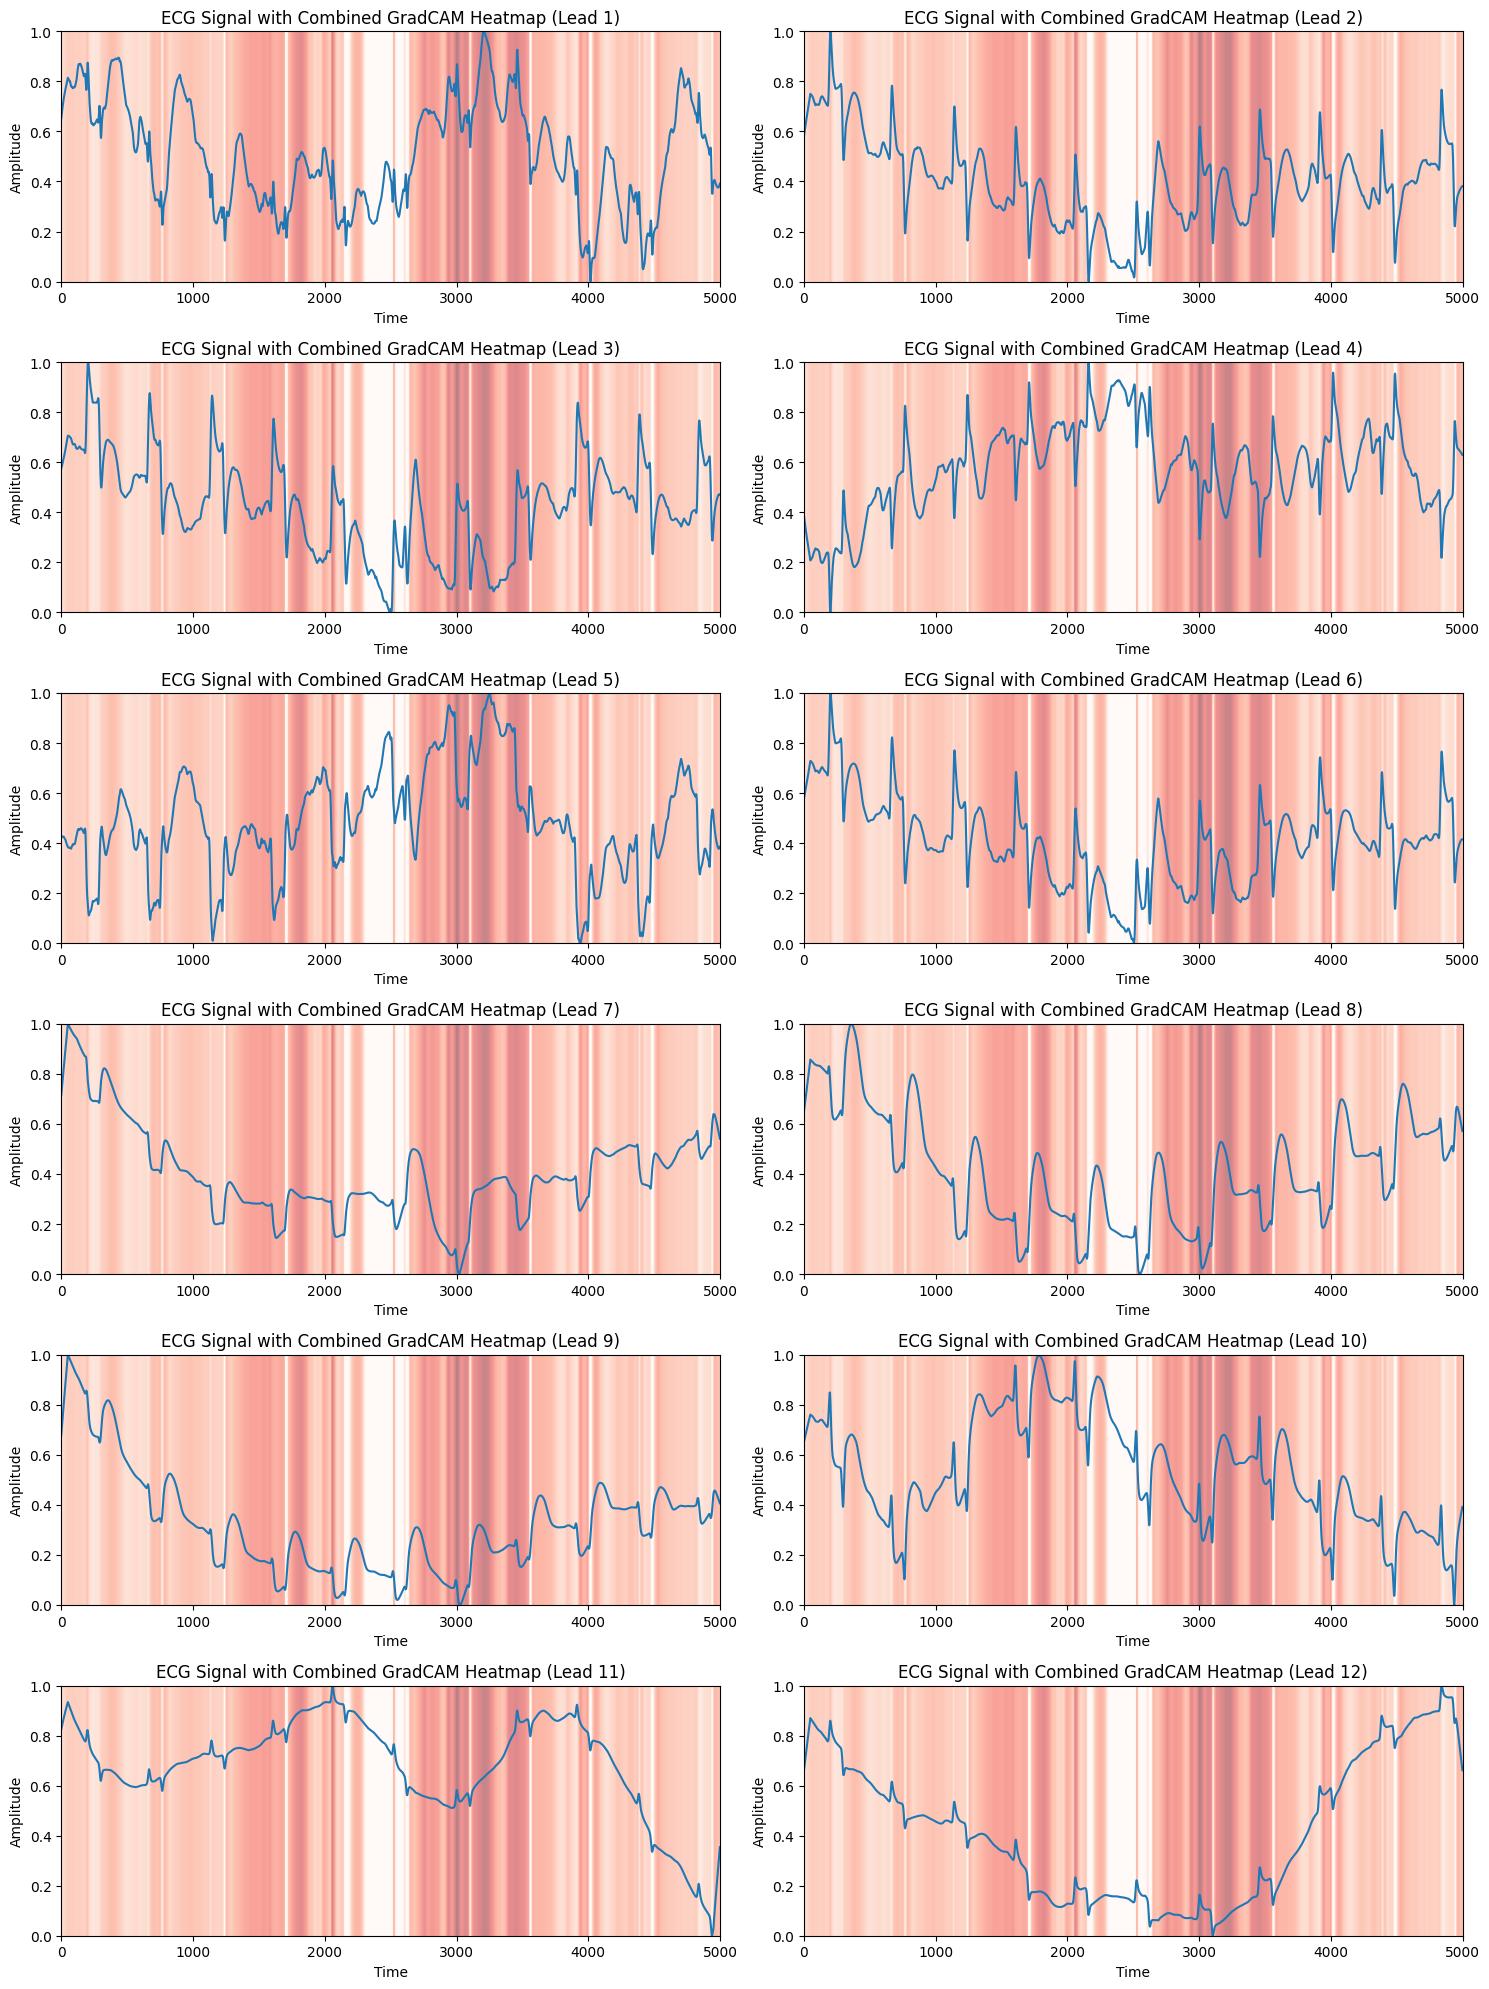

GradCAM visualization for all leads combined completed.


In [18]:
# Plot the result for all leads using the combined heatmap
fig, axes = plt.subplots(6, 2, figsize=(15, 20))
axes = axes.flatten()

for lead_number in range(12):
    ax = axes[lead_number]
    ax.plot(ecg_input[0][:, lead_number], label=f'ECG Signal (Lead {lead_number + 1})')
    heatmap_resized = np.interp(np.arange(0, ecg_input.shape[1]), np.linspace(0, len(heatmap_all_leads), len(heatmap_all_leads)), heatmap_all_leads)
    ax.imshow(np.expand_dims(heatmap_resized, axis=0), aspect='auto', cmap='Reds', alpha=0.5, extent=[0, ecg_input.shape[1], np.min(ecg_input[0][:, lead_number]), np.max(ecg_input[0][:, lead_number])])
    ax.set_title(f"ECG Signal with Combined GradCAM Heatmap (Lead {lead_number + 1})")
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')

plt.tight_layout()
plt.show()
print("GradCAM visualization for all leads combined completed.")